In [ ]:
# AI-Powered Communication Assistant with SQLite
# Author: Md Ashraf
# Notes: Emails fetched, analyzed, stored in SQLite, dashboard with Streamlit

# Install required packages (run once in terminal)
# pip install imapclient pyzmail36 textblob streamlit transformers torch pandas matplotlib seaborn

In [1]:
# Import libraries
import imapclient
import pyzmail
from textblob import TextBlob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import streamlit as st
from datetime import datetime, timedelta
import sqlite3

In [2]:
EMAIL = "Your Email Id"
PASSWORD = "Your Google App Password" 

imap_server = "imap.gmail.com"
imap_obj = imapclient.IMAPClient(imap_server, ssl=True)
imap_obj.login(EMAIL, PASSWORD)
imap_obj.select_folder('INBOX', readonly=True)

UIDs = imap_obj.search(['SINCE', (datetime.now() - timedelta(days=7)).strftime("%d-%b-%Y")])
emails = []

for uid in UIDs:
    raw_message = imap_obj.fetch([uid], ['BODY[]', 'FLAGS'])
    message = pyzmail.PyzMessage.factory(raw_message[uid][b'BODY[]'])
    subject = message.get_subject()
    if message.text_part:
        charset = message.text_part.charset if message.text_part.charset else 'utf-8'
        body = message.text_part.get_payload().decode(charset, errors='ignore')
    else:
        body = ""
    
    # Filter relevant support emails
    keywords = ['Support', 'Query', 'Request', 'Help']
    if any(k.lower() in subject.lower() for k in keywords):
        emails.append({
            "sender": message.get_addresses('from')[0][1],
            "subject": subject,
            "body": body,
            "date": message.get_decoded_header('date')
        })

In [4]:
# Sentiment Analysis & Priority Detection
def detect_sentiment(text):
    blob = TextBlob(text)
    if blob.sentiment.polarity > 0.1:
        return "Positive"
    elif blob.sentiment.polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

def detect_priority(text):
    urgent_keywords = ["urgent","immediately","critical","cannot access","stuck","asap"]
    return "Urgent" if any(k in text.lower() for k in urgent_keywords) else "Not Urgent"

for email in emails:
    email['sentiment'] = detect_sentiment(email['body'])
    email['priority'] = detect_priority(email['body'])


In [5]:
# Information Extraction
def extract_info(text):
    phone = re.findall(r'\+?\d[\d -]{8,12}\d', text)
    email_found = re.findall(r'\b[\w.-]+?@\w+?\.\w+?\b', text)
    request_summary = " ".join(text.split()[:20])  # First 20 words
    return phone, email_found, request_summary

for email in emails:
    phone, email_found, summary = extract_info(email['body'])
    email['phone'] = phone
    email['emails_found'] = email_found
    email['request_summary'] = summary


In [6]:
# AI Draft Response (Free local LLM)
generator = pipeline("text-generation", model="gpt2")

def generate_reply(text):
    prompt = f"Email: {text}\nDraft a professional, friendly reply:"
    reply = generator(prompt, max_length=150, do_sample=True)[0]['generated_text']
    return reply.split("Draft a professional")[0] 

for email in emails:
    email['draft_reply'] = generate_reply(email['body'])

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers

In [13]:
# SQLite Database Integration
conn = sqlite3.connect('emails.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS emails (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    sender TEXT,
    subject TEXT,
    body TEXT,
    date_received TEXT,
    sentiment TEXT,
    priority TEXT,
    phone TEXT,
    emails_found TEXT,
    request_summary TEXT,
    draft_reply TEXT
)
''')
conn.commit()

# Insert emails into database
for email in emails:
    cursor.execute('''
        INSERT INTO emails 
        (sender, subject, body, date_received, sentiment, priority, phone, emails_found, request_summary, draft_reply)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        email['sender'],
        email['subject'],
        email['body'],
        email['date'],
        email['sentiment'],
        email['priority'],
        str(email['phone']),
        str(email['emails_found']),
        email['request_summary'],
        email['draft_reply']
    ))
conn.commit()

# Read database into DataFrame for dashboard
df = pd.read_sql_query("SELECT * FROM emails", conn)


2025-09-06 14:08:51.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 14:08:51.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 14:08:51.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 14:08:51.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 14:08:51.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 14:08:51.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 14:08:51.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 14:08:51.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

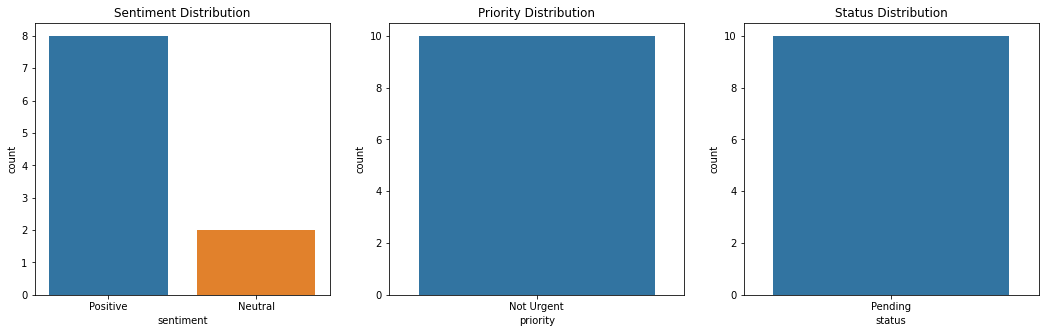

In [18]:
# Streamlit Dashboard
st.title("AI-Powered Communication Assistant Dashboard")

# Ensure 'status' column exists
if 'status' not in df.columns:
    df['status'] = 'Pending'

# Display emails
st.subheader("Filtered Emails")
st.dataframe(df[['sender','subject','body','date_received','sentiment','priority',
                 'phone','emails_found','request_summary','draft_reply','status']])

# Analytics
st.subheader("Analytics")

# Total emails in last 24 hours
from dateutil import parser

def safe_parse_date(date_str):
    try:
        return parser.parse(date_str)
    except:
        return datetime.now()

df['date_received_dt'] = df['date_received'].apply(safe_parse_date)
df['date_received_dt'] = df['date_received_dt'].apply(lambda x: x.replace(tzinfo=None) if x.tzinfo else x)

last_24h = datetime.now()
total_24h = df[df['date_received_dt'] >= (last_24h - timedelta(hours=24))].shape[0]

# Pending & Resolved counts
pending_count = df[df['status'] == 'Pending'].shape[0]
resolved_count = df[df['status'] == 'Resolved'].shape[0]

st.markdown(f"**Total emails in last 24h:** {total_24h}  |  **Pending:** {pending_count}  |  **Resolved:** {resolved_count}")

# Graphs
st.subheader("Visual Insights")

fig, ax = plt.subplots(1,3, figsize=(18,5))

sns.countplot(x='sentiment', data=df, ax=ax[0])
ax[0].set_title("Sentiment Distribution")

sns.countplot(x='priority', data=df, ax=ax[1])
ax[1].set_title("Priority Distribution")

sns.countplot(x='status', data=df, ax=ax[2])
ax[2].set_title("Status Distribution")

st.pyplot(fig)
